<a href="https://colab.research.google.com/github/NadaAdelMousa/NLP_Tweets_Hate_Speech/blob/main/Copy_of_Lab_1_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets.
0 -> no hate speech
1 -> contains hate speech

**Total Estimated Time = 90 Mins**

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Dataset

In [2]:
!gdown https://drive.google.com/uc?id=1EQCpEpOrVMQquHoEy94BkT4y51nlLUyb -O dataset.csv

Downloading...
From: https://drive.google.com/uc?id=1EQCpEpOrVMQquHoEy94BkT4y51nlLUyb
To: /content/dataset.csv
100% 3.10M/3.10M [00:00<00:00, 62.2MB/s]


In [4]:
df = pd.read_csv('dataset.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


### EDA

- check NaNs

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


- check duplicates

In [6]:
df.duplicated().any()

False

- show samples of data texts to find out required preprocessing steps

In [6]:
pd.set_option('display.max_colwidth',None)

In [7]:
df.sample(20)

,id,label,tweet
30891,30892,0,â #united states continuing jobless claims came in at 2.095m below forecasts (2.171m) in may 27 #blog #silvâ¦
2936,2937,0,looking at old posts from my old twitter account #2012 soooooooooo glad i'm not where i used to be #2016 #growth #loved #butgod ðð½
31526,31527,0,@user âallâwhoâretweetsâwantânewâfollowersâ â #tfbjp â #teamfollowback â #openfollow â #followback â â # â 32.71
458,459,0,thinking maybe i should have bought @user instead of @user #gettingold #becomingboring #notborderlands #goblizzard
26862,26863,0,@user ði'm finally breaking...ð . . . . . #depressed #depression #anxiety #ugly #selfhate #cuts #cutting #suiâ¦ htâ¦
30190,30191,0,what a lovely warm day and it's #saturday get to go to #lingfieldraces wishing everyone an amazing day!
17912,17913,0,rainy days... ð£ #rain #switzerland #need #sun #summer #instapic
27856,27857,0,"bbq tomorrow, why not ð¥âï¸#saturday #summer #smile #laugh #enjoy #family #bbq #barberloveâ¦"
8607,8608,0,this the worse day of my life straight up wtf mexico finna go kill myself brb #mexicovschile #neverforget #byeworld
11646,11647,0,crying at the big bang theory because howard's mum died! ð¢. #tbbt


- check dataset balancing

In [7]:
print(df['label'].value_counts())

0    29720
1     2242
Name: label, dtype: int64


In [8]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = df[(df['label']==0)] 
df_minority = df[(df['label']==1)] 
# upsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample with replacement
                                 n_samples= 2250, # to match majority class
                                 random_state=42)  # reproducible results
                                 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [9]:
df_shuffled = df_downsampled.sample(frac=1, random_state=1).reset_index()

In [10]:
print(df_shuffled['label'].value_counts())

0    2250
1    2242
Name: label, dtype: int64


- Cleaning and Preprocessing are:
    - 1
    - 2
    - 3

### Cleaning and Preprocessing

In [11]:
train_text = df_shuffled['tweet'].values
labels = df_shuffled['label'].values

In [12]:
from pathlib import Path
import os
import re
import html
import string

import unicodedata


import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    stop_words = stopwords.words('english')
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem or lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [14]:
def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]

In [15]:
trn_texts = normalize_corpus(train_text)

In [16]:
print(train_text[0])
print(trn_texts[0])

@user your fall is going to be a thing of wonder #resist #narcissist  #psychopath  #mysoginist  #clown #happynewyear2017
user fall go thing wonder resist narcissist psychopath mysoginist clown happynewyear


**If it takes 60 Mins till here, you are doing Great** <br>
**If not! You also are doing Great**

### Modelling

In [17]:
y_train = np.asarray(labels).astype('float32')

In [18]:
x_val = trn_texts[:1000]
partial_x_train = trn_texts[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [19]:
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(partial_x_train)

In [20]:
x_train_tok = tok.texts_to_sequences(partial_x_train)
x_val_tok = tok.texts_to_sequences(x_val)

In [21]:
print(x_train_tok[0])
print(y_train[0])

[1942, 13, 1943, 375]
1.0


####BOW

In [22]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train_bow = vectorize_sequences(x_train_tok)
x_val_bow = vectorize_sequences(x_val_tok)
print(x_train_bow[0])

[0. 0. 0. ... 0. 0. 0.]


In [23]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [25]:
checkpoint = EarlyStopping(monitor='val_binary_accuracy', mode='max')
callbacks_lst = [checkpoint]

history = model.fit(x_train_bow,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val_bow, y_val), 
                    callbacks=callbacks_lst)

Epoch 1/20
7/7 [==============================] - 2s 201ms/step - loss: 0.6816 - binary_accuracy: 0.6753 - val_loss: 0.6617 - val_binary_accuracy: 0.8050
Epoch 2/20
7/7 [==============================] - 0s 37ms/step - loss: 0.6312 - binary_accuracy: 0.8932 - val_loss: 0.6223 - val_binary_accuracy: 0.8280


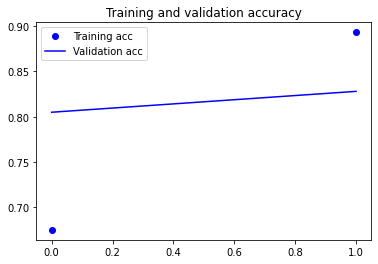

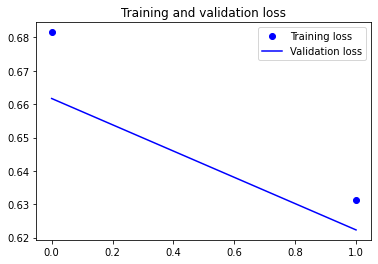

In [26]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Evaluation

In [28]:
y_pred = model.predict(x_val_bow)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

         0.0       0.73      0.90      0.81       402
         1.0       0.92      0.78      0.84       598

    accuracy                           0.83      1000
   macro avg       0.83      0.84      0.83      1000
weighted avg       0.84      0.83      0.83      1000



### Enhancement

- Using different N-grams
- Using different text representation technique

#### Done!